# Évolution temporelle du signal généré par l'oscillateur à pont de Wien


Soit l'oscillateur à pont de Wien suivant :


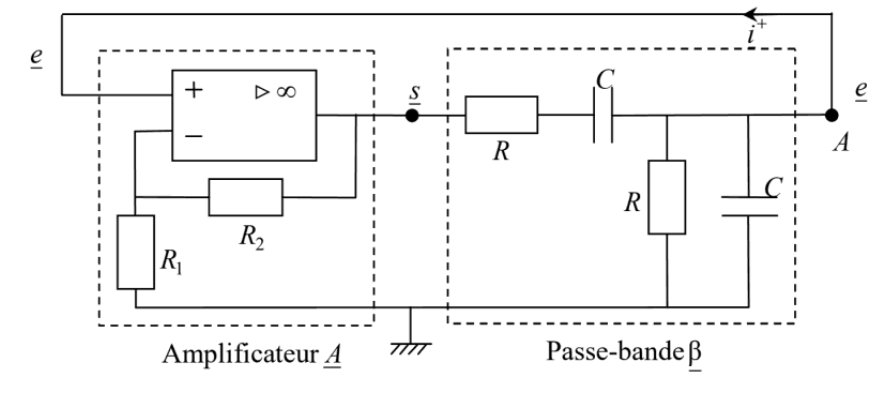

En régime linéaire, la partie ALI a pour fonction de transfert :
$$\underline{A}=\dfrac{R_1+R_2}{R_2}$$
La partie filtre de Wien a pour fonction de transfert :
$$\underline{\beta}=\dfrac{\text{j}RC\omega}{1+3\text{j}RC\omega-R^2C^2\omega^2}$$

&nbsp;
En exploitant les deux relations ci-dessus, et la condition de bouclage, on peut établir l'équation différentielle de l'oscillateur, en régime linéaire : 
$$\boxed{
R^2C^2\dfrac{\text{d}^2e}{\text{d}t^2}+\dfrac{RC}{R_2}(2R_2-R_1)\dfrac{\text{d}e}{\text{d}t}+e=0
}$$

&nbsp;
L'équation différentielle est du deuxième ordre à coefficients constants et fait apparaître la pulsation propre $\omega_0=1/RC$. Elle est conditionnellement stable. 

&nbsp;
L'apparition d'oscillations n'est possible que si l'équation différentielle est instable, soit $R_1>2R_2$.

&nbsp;
On crée donc les variables associées aux diverses grandeurs, ainsi qu'une condition initiale de "bruit électronique", sous la forme d'un vecteur `xv0` qui contient une tension nulle, mais une dérivée initiale non nulle.

## I. Résolution avec le solveur de python solve_ivp
> ### I.1 Étude numérique

In [30]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

On définit tout d'abord tous les paramètres propres aux deux blocs (en tenant compte d'une mesure de R et de C) :

In [48]:
### Données propres aux divers blocs électrocinétiques
## Montage amplificateur à ALI
R2 = 205000. # résistance N°1 de l'amplificateur
R1 = 10000. # résistance N°2 de l'amplificateur
Usat = 15. # tension de saturation de l'ALI

## Montage filtre passe-bande de Wien
R = np.mean([9.94e3, 9.90e3, 9.99e3]) # résistance du filtre issue de 3 mesures de R
u_R = np.std([9.94e3, 9.90e3, 9.99e3], ddof=1)
C = np.mean([100.2e-9, 96.7e-9, 94.9e-9]) # capacité du filtre issue de 3 mesures de C
u_C = np.std([100.2e-9, 96.7e-9, 94.9e-9], ddof=1)

## Calcul de la valeur moyenne de omega0 et de son incertitude de mesure
omega0_store = []
for i in range(100000):
    omega0_store.append(1/((R+np.random.uniform(-1,1)*u_R)*(C+np.random.uniform(-1,1)*u_C))) # pulsation propre
omega0 = np.mean(omega0_store)
u_omega0 = np.std(omega0_store, ddof=1)
print(omega0)

1034.1940219907005


On définit les conditions initiales pour les tensions e et s : on choisit ici de commencer avec une petite perturbation sur la dérivée de la tension e(t), et e(t=0) est choisi nulle, le tout est stockée dans la liste xv0.


In [49]:
## Bruit électronique initial servant de condition initiale
xv0 = [1e-3,0]
print(xv0)

[0.001, 0]


On code alors l'équation différentielle sous la forme vectorielle compatible avec `solve_ivp` :
$$\dfrac{\text{d}}{\text{d}t}X=f(X,t)$$

où $X=\left[\begin{array}{c} u_s \\ \dot{u_s} \end{array}\right]$ est la grandeur que l'on cherche à résoudre, on la note `xv`.

et la fonction vectorielle $f$, codé sous le nom `osc_QS_wien`, vaut :

$$f(X,t)=\left[\begin{array}{c} \dot{u_s} \\ -\frac{1}{R^2C^2}u_s-\frac{2R_2-R_1}{CR_2R_1}\dot{u_s} \end{array}\right]$$

In [50]:
# Définition du système d'équation différentielle
### Fonction décrivant le comportement de l'oscillateur
def osc_QS_wien(t,xv): 
        return [xv[1],-(2*R1-R2)/(C*R1*R)*xv[1]-xv[0]/((R*C)**2)]

t représente la variable temps et xv la variable portant l'inconnue e(t) et sa dérivée première.

On s'occupe du temps, en définissant les instants initial et final et en créant la liste des différents temps : ici on prend 100 points pour tracer l'axe temporel.

In [51]:
### Paramètres numériques d'intégration
Tmax = 100*(2*np.pi/omega0)
nd = 5000
t = np.linspace(0.0,Tmax,nd)

On utilise alors solve_ivp du package scipy.integrate. 

In [52]:
#solution = solve_ivp(systeme, [t0, tf], [C_0, C_1], method='RK45',max_step=0.1)

### Intégration numérique à l'aide de solve_ivp et des conditions initiales de bruit
xv = solve_ivp(osc_QS_wien,[0,Tmax],xv0,method='RK45',max_step=Tmax/nd)


On a rentré comme argument à la fonction solve_ivp tout d'abord le système différentiel, puis les instants de départ et de fin, puis les conditions initiales, puis la méthode d'intégration numérique utilisé dans l'algorithme solve_ivp - ici Runge Kutta d'ordre 5 - et enfin le pas maximum d'intégration. 
solve_ivp renvoie un tableau avec différentes informations dont notamment le temps, et la solution, appelables via xv.t et xv.y.

Il ne reste plus qu'à tracer la solution avec plot : 

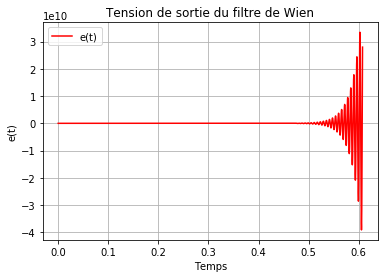

In [53]:
## On trace l'évolution temporelle de la tension de sortie du filtre
plt.plot(xv.t, xv.y[0], label="e(t)", color='red')
plt.ylabel('e(t)')
plt.xlabel("Temps")
plt.title("Tension de sortie du filtre de Wien")
plt.grid(which="both")
plt.legend()
plt.show()


Il suffit alors de jouer avec le coefficient A pour modifier l'évolution temporelle de la tension de sortie.

Néanmoins en fonctionnant ainsi, on ne tient pas compte de l'éventuelle saturation de l'ALI. On propose alors une deuxième manière de résoudre le système d'équation différentielle conditionnelle, cette fois-ci en utilisant la méthode d'Euler directement.

> ### I.2 Analyse fréquentielle du signal

Il s'agit ici de réaliser la transformée de Fourier d'un signal discret. Mathématiquement, pour un signal numérique x$[k]$ contenant N valeurs, cela correspond à la formule suivante :
\begin{equation}
X[k] = \sum_{n=0}^{N-1} x[n]*exp(-j 2 \pi \cdot \frac{k\cdot n}{N})
\end{equation}

On obtient alors la transformée discrète de Fourier notée X, qui est une fonction à valeurs complexes.

Numériquement, Il existe plusieurs implantations dans Python de la FFT, et nous allons utiliser celle du package scipy.fft. 


**scipy.fft.fft(x, n=None, axis=- 1, norm=None, overwrite_x=False, workers=None, *, plan=None)** 


> x est un array qui peut être complexe,

> n est un entier qui spécifie la taille de l'axe de la transformée, par défaut c'est la taille de x,

> Pour les autres options, il faut se référer à l'aide de scipy.


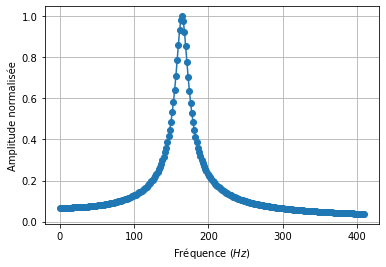

La fréquence dominante du signal de sortie est :  1.644e+02 +/- 9.494e-01 Hz
La fréquence propre est :  1.646e+02 Hz


In [54]:
from scipy.fft import fft, rfft, fftfreq # les deux fonctions que l'on peut utiliser, rfft fonctionne si x est réel
                                        # fftfreq retourne la liste des fréquences 

X=xv.y[0]    
Y = np.abs(np.fft.rfft(X)/(len(X)//2+1))
nf=nd/20 # Affichage réduit de la plage de fréquences calculées
Y = Y[:int(nf)]
frq = np.fft.rfftfreq(len(X), d=Tmax/(nd-1)) # Création de l'axe des abscisses
frq = frq[:int(nf)]
imax=np.argmax(Y) # On cherche la valeur maximale de la FFT pour normalisation

plt.figure('FFT')
plt.plot(frq,Y/np.max(Y), '-o') # On normalise la FFT par le maximum du spectre
plt.grid(True)
plt.xlabel(r'Fréquence $(Hz)$')
plt.ylabel(r'Amplitude normalisée')
plt.show()

print("La fréquence dominante du signal de sortie est : ",format(frq[imax],"#.3e"),"+/-", format((frq[1]-frq[0])/np.sqrt(3), "#.3e"),"Hz")
print("La fréquence propre est : ",format(omega0/(2*np.pi),"#.3e"),"Hz")

## II. Résolution du système différentiel en tenant compte de la saturation 
### II.1 Étude numérique

On reprend le schéma du circuit électrique et on montre que la tension e(t) ne vérifie plus la même équation différentielle, car désormais s vaut $\pm$ V$_{sat}$.
Montrer que la nouvelle équation s'écrit :

$$\boxed{
R^2C^2\dfrac{\text{d}^2e}{\text{d}t^2}+3RC\dfrac{\text{d}e}{\text{d}t}+e=0
}$$

In [55]:
### Fonction décrivant le comportement de l'oscillateur
def osc_QS_wien(t,xv): 
    # Si la tension de sortie est plus faible que la condition de bascule le montage est instable
    if abs(xv[0]) <= (R2/(R1+R2))*Usat :
        return [xv[1],-(2*R2-R1)/(C*R2*R)*xv[1]-xv[0]/((R*C)**2)]
    # Sinon le montage est stabilisé par le passage en saturation de l'ALI
    else :
        return [xv[1],-3/(R*C)*xv[1]-xv[0]/((R*C)**2)]

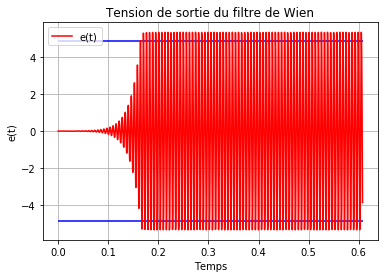

In [56]:

### Intégration numérique à l'aide de solve_ivp et des conditions initiales de bruit
xvv = solve_ivp(osc_QS_wien,[0,Tmax],xv0,method='RK45',max_step=Tmax/nd)


## On trace l'évolution temporelle de la tension de sortie du filtre
plt.plot(xvv.t, xvv.y[0], label="e(t)", color='red')
plt.hlines(R2*Usat/(R1+R2),min(t),max(t),color='b')
plt.hlines(-R2*Usat/(R1+R2),min(t),max(t),color='b')
plt.ylabel('e(t)')
plt.xlabel("Temps")
plt.title("Tension de sortie du filtre de Wien")
plt.grid(which="both")
plt.legend()
plt.show()



Les lignes bleues représentent les frontières $\left|u_s\right|\leq \frac{R_2}{R_1+R_2}U_\text{sat}$. On peut alors remarquer l'effet stabilisant du fonctionnement en saturation de l'ALI.

La bascule périodique entre régime linéaire et de saturation du fonctionnement de l'ALI a pour conséquence un enrichissement spectral du signal obtenu, d'autant plus flagrant que la durée passée en mode de saturation est grande.

&nbsp;
On peut le vérifier en traçant le spectre du signal, et en modifiant les paramètres de fonctionnement de l'oscillateur.

### II.2 Étude fréquentielle


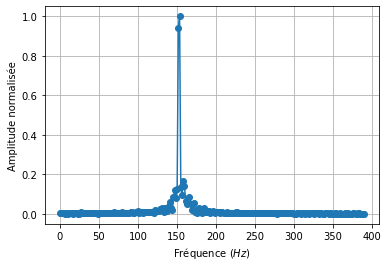

La fréquence dominante du signal de sortie est :  1.535e+02 +/- 9.045e-01 Hz
La fréquence propre est :  1.646e+02 Hz


In [60]:
from scipy.fft import fft, rfft

X=xvv.y[0]    
Y = np.abs(np.fft.rfft(X)/(len(X)//2+1))
nf=nd/20 # Affichage réduit de la plage de fréquences calculées
Y = Y[:int(nf)]
frq = np.fft.rfftfreq(len(X), d=Tmax/(nd-1)) # Création de l'axe des abscisses
frq = frq[:int(nf)]
imax=np.argmax(Y) # On cherche la valeur maximale de la FFT pour normalisation

plt.figure('FFT')
plt.plot(frq,Y/np.max(Y), '-o') # On normalise la FFT par le maximum du spectre
plt.grid(True)
plt.xlabel(r'Fréquence $(Hz)$')
plt.ylabel(r'Amplitude normalisée')
plt.show()

print("La fréquence dominante du signal de sortie est : ",format(frq[imax],"#.3e"),"+/-", format((frq[1]-frq[0])/np.sqrt(3), "#.3e"),"Hz")
print("La fréquence propre est : ",format(omega0/(2*np.pi),"#.3e"),"Hz")